# Preparation of initial box for coexsistence simulations

In [19]:
import numpy as np, sys, os, glob
import matplotlib.pylab as plt
import MDAnalysis
import pickle
from MDAnalysis import transformations


In [20]:
standard_sim=os.path.abspath('template/')
ice='IceII'
press_box = ['1000','2000', '3000', '4000']
single_pressure=None #'7000'
#temps=np.array([245,250,255,260,265,270])

### First step: equilibrate ice box

In [21]:
sims = dict()
for a in press_box[:]:
    fold='BOX_EQUIL_{}atm/'.format(a)
    if single_pressure==None or single_pressure in fold:
        #sims[fold] = dict()
        #sims[fold]['p']=a[0]
        os.system('mkdir -p {}'.format(fold))
        os.system('cp -r {}/* {}'.format(standard_sim,fold))
        cmd='sed -i "" "s#variable .* pressure .*#variable        pressure equal {}#g" {}/in.pressure'.format(a,fold)
        os.system(cmd)

### Second step: Determine average box dimensions

In [22]:
def extract_form_log(fn):
    lines=open(fn,'r').readlines()
    start=np.where([('Step' in l) for l in lines])[-1][0]
    data={keyi.lower(): []  for keyi in lines[start].split()}
    for l in lines[start+1:]:
        ls=l.split()
        try:
            if ls[0].isdigit():
                for i, key in enumerate(data.keys()):
                    data[key].append(float(ls[i]))
        
            else:
                break
        except:
            break
    for key in data.keys():
        data[key]=np.array(data[key])
    return data

In [23]:
box_equil=dict()
for f in glob.glob('BOX_EQUIL_*/log.lammps'): 
    box_equil[f.replace('/log.lammps','')]=extract_form_log(f)


with open('box_size.pickle', 'wb') as handle:
    pickle.dump(box_equil, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('box_size.pickle', 'rb') as handle:
    box_equil = pickle.load(handle)
print(box_equil.keys())

dict_keys(['BOX_EQUIL_4000atm', 'BOX_EQUIL_1000atm', 'BOX_EQUIL_2000atm', 'BOX_EQUIL_3000atm'])


Text(0, 0.5, 'v/Å$^3$')

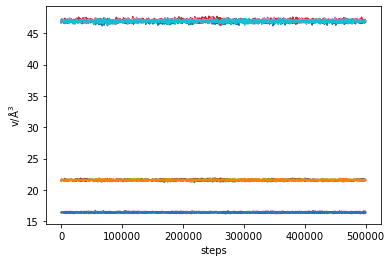

In [24]:
for key in box_equil.keys():
    plt.plot(box_equil[key]['step'],box_equil[key]['lx'])
    plt.plot(box_equil[key]['step'],box_equil[key]['lz'])
    plt.plot(box_equil[key]['step'],box_equil[key]['ly'])
plt.xlabel('steps')
plt.ylabel(r'v/Å$^3$')

In [30]:
for fold in box_equil.keys():
    sim=box_equil[fold]
                                                                                                                                                                             
    u = MDAnalysis.Universe(fold+'/ice_equil.data', in_memory=True)
    NIGNORE=int(0.25*len(box_equil[key]['step']))
    print(u.dimensions)

    lx=np.mean(sim['lx'][NIGNORE:])
    xy=np.mean(sim['xy'][NIGNORE:])
    xz=np.mean(sim['xz'][NIGNORE:])
    ly=np.mean(sim['ly'][NIGNORE:])
    yz=np.mean(sim['yz'][NIGNORE:])
    lz=np.mean(sim['lz'][NIGNORE:])
    A=np.array([[lx,0,0],
                 [xy,ly,0],
                 [xz,yz,lz]])
    dimensions_new=MDAnalysis.lib.mdamath.triclinic_box(A[0], A[1], A[2])
    print(dimensions_new)
    u.atoms.positions[:,0] = u.coord.positions[:,0]*lx/u.dimensions[0]
    u.atoms.positions[:,1] = u.coord.positions[:,1]*ly/u.dimensions[1]
    u.atoms.positions[:,2] = u.coord.positions[:,2]*lz/u.dimensions[2]

    u.dimensions[0]=dimensions_new[0]
    u.dimensions[1]=dimensions_new[1]
    u.dimensions[2]=dimensions_new[2]
    u.dimensions[3]=dimensions_new[3]
    u.dimensions[4]=dimensions_new[4]
    u.dimensions[5]=dimensions_new[5]
    for ts in u.trajectory:
        u.atoms.wrap()
    u.atoms.write(fold+'/ice_avg_equil.data')

[ 46.762047  23.498184  25.568764  56.625717 135.63657  113.34229 ]
[ 46.82053   23.410572  25.776379  56.594822 135.68439  113.19787 ]
dict_items([('bond', <TopologyGroup containing 1296 bonds>), ('angle', <TopologyGroup containing 648 angles>), ('dihedral', <TopologyGroup containing 0 dihedrals>), ('improper', <TopologyGroup containing 0 impropers>)])
bond ['1']
angle ['1']
dihedral []
improper []
[ 46.998203  23.417042  25.897589  56.807495 135.36215  113.132126]
[ 47.052113  23.526999  25.920723  56.57172  135.51514  113.14322 ]
dict_items([('bond', <TopologyGroup containing 1296 bonds>), ('angle', <TopologyGroup containing 648 angles>), ('dihedral', <TopologyGroup containing 0 dihedrals>), ('improper', <TopologyGroup containing 0 impropers>)])
bond ['1']
angle ['1']
dihedral []
improper []
[ 46.87286   23.416428  25.871344  56.78155  135.54697  112.83146 ]
[ 46.972275  23.486824  25.870375  56.576878 135.57715  113.16831 ]
dict_items([('bond', <TopologyGroup containing 1296 bonds>

### Third step: Melt half the box

In [31]:
for a in press_box[:]:
    fold='BOX_MELT_{}atm/'.format(a)
    os.system('mkdir -p {}'.format(fold))
    os.system('cp -r {}/ice_avg_equil.data {}'.format(fold.replace('MELT','EQUIL'),fold))
    os.system('cp -r {}/* {}'.format(standard_sim,fold))
    cmd='sed -i "" "s#variable .* pressure .*#variable        pressure equal {}#g" {}/in.pressure'.format(a,fold)
    os.system(cmd)

### Fourth step: collect data files

In [5]:
fold_out='COEX_BOXES/'
os.system('mkdir -p {}'.format(fold_out))
for a in press_box[:]:
    fold='BOX_MELT_{}atm/'.format(a)
    os.system('cp {}/water.data.equil {}/{}'.format(fold,fold_out,'water_{}atm.data'.format(a)))

### Convert notebook to python script

In [1]:
!jupyter nbconvert --to script Prepare_coexsistence.ipynb


[NbConvertApp] Converting notebook Prepare_coexsistence.ipynb to script
[NbConvertApp] Writing 3646 bytes to Prepare_coexsistence.py
